In [1]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import nltk
#nltk.download()
import sklearn


from tensorflow import keras
from keras.preprocessing.text import text_to_word_sequence
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn import svm
from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import roc_auc_score
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier


In [2]:
dataset = pd.read_csv('BBC News Train.csv')
test_set = pd.read_csv("BBC News Test.csv")

In [3]:
dataset.head()

,ArticleId,Text,Category
0,1833,worldcom ex-boss launches defence lawyers defe...,business
1,154,german business confidence slides german busin...,business
2,1101,bbc poll indicates economic gloom citizens in ...,business
3,1976,lifestyle governs mobile choice faster bett...,tech
4,917,enron bosses in $168m payout eighteen former e...,business


In [4]:
target_category = dataset['Category'].unique()
print(target_category)

['business' 'tech' 'politics' 'sport' 'entertainment']


In [5]:
dataset['categoryId'] = dataset['Category'].factorize()[0]
dataset.head()

,ArticleId,Text,Category,categoryId
0,1833,worldcom ex-boss launches defence lawyers defe...,business,0
1,154,german business confidence slides german busin...,business,0
2,1101,bbc poll indicates economic gloom citizens in ...,business,0
3,1976,lifestyle governs mobile choice faster bett...,tech,1
4,917,enron bosses in $168m payout eighteen former e...,business,0


In [6]:
category = dataset[["Category","categoryId"]].drop_duplicates().sort_values('categoryId')
category

,Category,categoryId
0,business,0
3,tech,1
5,politics,2
6,sport,3
7,entertainment,4


In [7]:
dataset.groupby('Category').categoryId.count()

Category
business         336
entertainment    273
politics         274
sport            346
tech             261
Name: categoryId, dtype: int64

# Data Visualization

<AxesSubplot:xlabel='Category'>

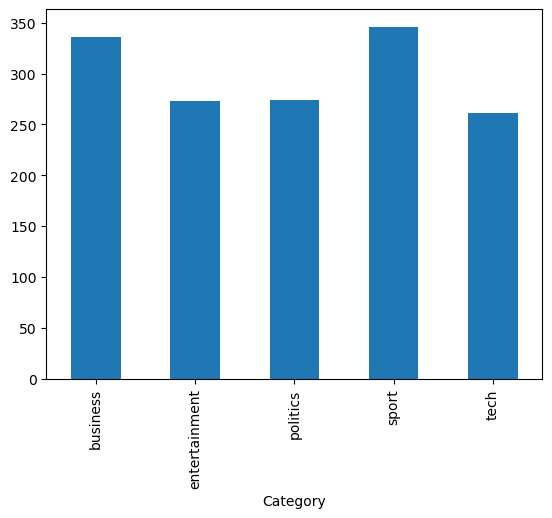

In [8]:
dataset.groupby('Category').categoryId.count().plot.bar(ylim=0)

In [9]:
text = dataset["Text"] 
text.head()

0    worldcom ex-boss launches defence lawyers defe...
1    german business confidence slides german busin...
2    bbc poll indicates economic gloom citizens in ...
3    lifestyle  governs mobile choice  faster  bett...
4    enron bosses in $168m payout eighteen former e...
Name: Text, dtype: object

In [10]:
category = dataset["Category"]
category.head()

0    business
1    business
2    business
3        tech
4    business
Name: Category, dtype: object

# Data Preprocessing

In [11]:
def preprocessDataset(train_text):
       
    #word tokenization using text-to-word-sequence
    train_text= str(train_text)
    tokenized_train_set = text_to_word_sequence(train_text,filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n',lower=True,split=" ")
        
    #stop word removal
    stop_words = set(stopwords.words('english'))
    stopwordremove = [i for i in tokenized_train_set if not i in stop_words]
        
     
    #join words into sentence
    stopwordremove_text = ' '.join(stopwordremove)
        
        
    #remove numbers
    numberremove_text = ''.join(c for c in stopwordremove_text if not c.isdigit())
       
        
    #--Stemming--
    stemmer= PorterStemmer()

    stem_input=nltk.word_tokenize(numberremove_text)
    stem_text=' '.join([stemmer.stem(word) for word in stem_input])
        
        
    lemmatizer = WordNetLemmatizer()

    def get_wordnet_pos(word):
        """Map POS tag to first character lemmatize() accepts"""
        tag = nltk.pos_tag([word])[0][1][0].upper()
        tag_dict = {"J": wordnet.ADJ,
                "N": wordnet.NOUN,
                "V": wordnet.VERB,
                "R": wordnet.ADV}

        return tag_dict.get(tag, wordnet.NOUN)

    lem_input = nltk.word_tokenize(stem_text)
    lem_text= ' '.join([lemmatizer.lemmatize(w, get_wordnet_pos(w)) for w in lem_input])
        
    return lem_text



In [12]:
dataset['Text'] = dataset['Text'].apply(preprocessDataset)
text = dataset['Text']
category = dataset['Category']
text.head()

LookupError: 
**********************************************************************
  Resource [93mpunkt[0m not found.
  Please use the NLTK Downloader to obtain the resource:

  [31m>>> import nltk
  >>> nltk.download('punkt')
  [0m
  For more information see: https://www.nltk.org/data.html

  Attempted to load [93mtokenizers/punkt/english.pickle[0m

  Searched in:
    - 'C:\\Users\\mahmu/nltk_data'
    - 'C:\\Users\\mahmu\\anaconda3\\nltk_data'
    - 'C:\\Users\\mahmu\\anaconda3\\share\\nltk_data'
    - 'C:\\Users\\mahmu\\anaconda3\\lib\\nltk_data'
    - 'C:\\Users\\mahmu\\AppData\\Roaming\\nltk_data'
    - 'C:\\nltk_data'
    - 'D:\\nltk_data'
    - 'E:\\nltk_data'
    - ''
**********************************************************************


# Split train set

In [ ]:
X_train, X_test, Y_train, Y_test = train_test_split(text,category, test_size = 0.2, random_state = 60,shuffle=True, stratify=category)

print(len(X_train))
print(len(X_test))

### SVM 

In [ ]:
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score

modelSVC = Pipeline([('tfidf', TfidfVectorizer()),
               ('clf', SVC(probability=True)),
              ])


#modelSVC = SVC(probability=True)
modelSVC.fit(X_train,Y_train)

test_predict = modelSVC.predict(X_test)

train_accuracy = round(modelSVC.score(X_train,Y_train)*100)
test_accuracy =round(accuracy_score(test_predict, Y_test)*100)


print("SVM Train Accuracy Score : {}% ".format(train_accuracy ))
print("SVM Test Accuracy Score  : {}% ".format(test_accuracy ))
print()
print(classification_report(test_predict, Y_test, target_names=target_category))

In [ ]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import cohen_kappa_score
cmSVC = confusion_matrix(Y_test, modelSVC.predict(X_test))

#If we use TP TN FP and FN of below's comment we get range
#FP = cmSVC.sum(axis=0) - np.diag(cmSVC)  
#FN = cmSVC.sum(axis=1) - np.diag(cmSVC)
#TP = np.diag(cmSVC)
#TN = cmSVC.sum() - (FP + FN + TP)

TP = cmSVC[1,1]  
TN = cmSVC[0,0] 
FP = cmSVC[0,1] 
FN = cmSVC[1,0] 

# Sensitivity, hit rate, recall, or true positive rate
TPR = TP/float(TP+FN)
# Specificity or true negative rate
TNR = TN/float(TN+FP) 
# Precision or positive predictive value
PPV = TP/float(TP+FP)
# Negative predictive value
NPV = TN/float(TN+FN)
# Fall out or false positive rate
FPR = FP/float(FP+TN)
# False negative rate
FNR = FN/float(TP+FN)
# False discovery rate
FDR = FP/float(TP+FP)
totalSVC=sum(sum(cmSVC))
Accuracy = (TN+TP)/totalSVC
# MCC
val = (TP * TN) - (FP * FN)
MCC_SVC = val / np.sqrt((TP + FP) * (TP + FN) * (TN + FP) * (TN + FN))
# Cohen Kappa
Y_pred = modelSVC.predict(X_test)
cohen_score = cohen_kappa_score(Y_test, Y_pred)

print("Sensitivity/TPR: " + str(TPR))
print("FPR: " + str(FPR))
print("Specificity/TNR: " + str(TNR))
print("MCC: " + str(MCC_SVC))
print("Cohen Kappa: " + str(cohen_score))

In [ ]:
from sklearn.model_selection import cross_val_score
cv_score_for_SVC = cross_val_score(modelSVC, X_train, Y_train, cv = 10)
cv_score_for_SVC

### KNN

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score

modelKNN = Pipeline([('tfidf', TfidfVectorizer()),
               ('clf', KNeighborsClassifier()),
              ])


#modelSVC = SVC(probability=True)
modelKNN.fit(X_train,Y_train)

test_predict = modelKNN.predict(X_test)

train_accuracy = round(modelKNN.score(X_train,Y_train)*100)
test_accuracy =round(accuracy_score(test_predict, Y_test)*100)


print("KNN Train Accuracy Score : {}% ".format(train_accuracy ))
print("KNN Test Accuracy Score  : {}% ".format(test_accuracy ))
print()
print(classification_report(test_predict, Y_test, target_names=target_category))

In [ ]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import cohen_kappa_score
cmSVC = confusion_matrix(Y_test, modelKNN.predict(X_test))

#If we use TP TN FP and FN of below's comment we get range
#FP = cmSVC.sum(axis=0) - np.diag(cmSVC)  
#FN = cmSVC.sum(axis=1) - np.diag(cmSVC)
#TP = np.diag(cmSVC)
#TN = cmSVC.sum() - (FP + FN + TP)

TP = cmSVC[1,1]  
TN = cmSVC[0,0] 
FP = cmSVC[0,1] 
FN = cmSVC[1,0] 

# Sensitivity, hit rate, recall, or true positive rate
TPR = TP/float(TP+FN)
# Specificity or true negative rate
TNR = TN/float(TN+FP) 
# Precision or positive predictive value
PPV = TP/float(TP+FP)
# Negative predictive value
NPV = TN/float(TN+FN)
# Fall out or false positive rate
FPR = FP/float(FP+TN)
# False negative rate
FNR = FN/float(TP+FN)
# False discovery rate
FDR = FP/float(TP+FP)
totalSVC=sum(sum(cmSVC))
Accuracy = (TN+TP)/totalSVC
# MCC
val = (TP * TN) - (FP * FN)
MCC_SVC = val / np.sqrt((TP + FP) * (TP + FN) * (TN + FP) * (TN + FN))
# Cohen Kappa
Y_pred = modelKNN.predict(X_test)
cohen_score = cohen_kappa_score(Y_test, Y_pred)

print("Sensitivity/TPR: " + str(TPR))
print("FPR: " + str(FPR))
print("Specificity/TNR: " + str(TNR))
print("MCC: " + str(MCC_SVC))
print("Cohen Kappa: " + str(cohen_score))

In [ ]:
from sklearn.model_selection import cross_val_score
cv_score_for_KNN = cross_val_score(modelKNN, X_train, Y_train, cv = 10)
cv_score_for_KNN

### Logistic Regression

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

modelLR = Pipeline([('tfidf', TfidfVectorizer()),
               ('clf', LogisticRegression()),
              ])


#modelSVC = SVC(probability=True)
modelLR.fit(X_train,Y_train)

test_predict = modelLR.predict(X_test)

train_accuracy = round(modelLR.score(X_train,Y_train)*100)
test_accuracy =round(accuracy_score(test_predict, Y_test)*100)


print("LR Train Accuracy Score : {}% ".format(train_accuracy ))
print("LR Test Accuracy Score  : {}% ".format(test_accuracy ))
print()
print(classification_report(test_predict, Y_test, target_names=target_category))

In [ ]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import cohen_kappa_score
cmSVC = confusion_matrix(Y_test, modelLR.predict(X_test))

#If we use TP TN FP and FN of below's comment we get range
#FP = cmSVC.sum(axis=0) - np.diag(cmSVC)  
#FN = cmSVC.sum(axis=1) - np.diag(cmSVC)
#TP = np.diag(cmSVC)
#TN = cmSVC.sum() - (FP + FN + TP)

TP = cmSVC[1,1]  
TN = cmSVC[0,0] 
FP = cmSVC[0,1] 
FN = cmSVC[1,0] 

# Sensitivity, hit rate, recall, or true positive rate
TPR = TP/float(TP+FN)
# Specificity or true negative rate
TNR = TN/float(TN+FP) 
# Precision or positive predictive value
PPV = TP/float(TP+FP)
# Negative predictive value
NPV = TN/float(TN+FN)
# Fall out or false positive rate
FPR = FP/float(FP+TN)
# False negative rate
FNR = FN/float(TP+FN)
# False discovery rate
FDR = FP/float(TP+FP)
totalSVC=sum(sum(cmSVC))
Accuracy = (TN+TP)/totalSVC
# MCC
val = (TP * TN) - (FP * FN)
MCC_SVC = val / np.sqrt((TP + FP) * (TP + FN) * (TN + FP) * (TN + FN))
# Cohen Kappa
Y_pred = modelLR.predict(X_test)
cohen_score = cohen_kappa_score(Y_test, Y_pred)

print("Sensitivity/TPR: " + str(TPR))
print("FPR: " + str(FPR))
print("Specificity/TNR: " + str(TNR))
print("MCC: " + str(MCC_SVC))
print("Cohen Kappa: " + str(cohen_score))

In [ ]:
from sklearn.model_selection import cross_val_score
cv_score_for_LR = cross_val_score(modelLR, X_train, Y_train, cv = 10)
cv_score_for_LR

# Multinomial Naive Bayes

In [ ]:
modelNB = Pipeline([('tfidf', TfidfVectorizer()),
               ('clf', MultinomialNB()),
              ])
modelNB.fit(X_train,Y_train)

test_predict = modelNB.predict(X_test)

train_accuracy = round(modelNB.score(X_train,Y_train)*100)
test_accuracy =round(accuracy_score(test_predict, Y_test)*100)


print("Naive Bayes Train Accuracy Score : {}% ".format(train_accuracy ))
print("Naive Bayes Test Accuracy Score  : {}% ".format(test_accuracy ))
print()
print(classification_report(test_predict, Y_test, target_names=target_category))


In [ ]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import cohen_kappa_score
cmSVC = confusion_matrix(Y_test, modelNB.predict(X_test))

#If we use TP TN FP and FN of below's comment we get range
#FP = cmSVC.sum(axis=0) - np.diag(cmSVC)  
#FN = cmSVC.sum(axis=1) - np.diag(cmSVC)
#TP = np.diag(cmSVC)
#TN = cmSVC.sum() - (FP + FN + TP)

TP = cmSVC[1,1]  
TN = cmSVC[0,0] 
FP = cmSVC[0,1] 
FN = cmSVC[1,0] 

# Sensitivity, hit rate, recall, or true positive rate
TPR = TP/float(TP+FN)
# Specificity or true negative rate
TNR = TN/float(TN+FP) 
# Precision or positive predictive value
PPV = TP/float(TP+FP)
# Negative predictive value
NPV = TN/float(TN+FN)
# Fall out or false positive rate
FPR = FP/float(FP+TN)
# False negative rate
FNR = FN/float(TP+FN)
# False discovery rate
FDR = FP/float(TP+FP)
totalSVC=sum(sum(cmSVC))
Accuracy = (TN+TP)/totalSVC
# MCC
val = (TP * TN) - (FP * FN)
MCC_SVC = val / np.sqrt((TP + FP) * (TP + FN) * (TN + FP) * (TN + FN))
# Cohen Kappa
Y_pred = modelNB.predict(X_test)
cohen_score = cohen_kappa_score(Y_test, Y_pred)

print("Sensitivity/TPR: " + str(TPR))
print("FPR: " + str(FPR))
print("Specificity/TNR: " + str(TNR))
print("MCC: " + str(MCC_SVC))
print("Cohen Kappa: " + str(cohen_score))

In [ ]:
from sklearn.model_selection import cross_val_score
cv_score_for_NB = cross_val_score(modelNB, X_train, Y_train, cv = 10)
cv_score_for_NB

# Decision Tree

In [ ]:
modelDTC = Pipeline([('tfidf', TfidfVectorizer()),
                ('dt', DecisionTreeClassifier()),
               ])

modelDTC.fit(X_train, Y_train)

test_predict = modelDTC.predict(X_test)

train_accuracy = round(modelDTC.score(X_train,Y_train)*100)
test_accuracy =round(accuracy_score(test_predict, Y_test)*100)

print("Decision Tree Train Accuracy Score : {}% ".format(train_accuracy ))
print("Decision Tree Test Accuracy Score  : {}% ".format(test_accuracy ))
print()
print(classification_report(test_predict, Y_test, target_names=target_category))

In [ ]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import cohen_kappa_score
cmSVC = confusion_matrix(Y_test, modelDTC.predict(X_test))

#If we use TP TN FP and FN of below's comment we get range
#FP = cmSVC.sum(axis=0) - np.diag(cmSVC)  
#FN = cmSVC.sum(axis=1) - np.diag(cmSVC)
#TP = np.diag(cmSVC)
#TN = cmSVC.sum() - (FP + FN + TP)

TP = cmSVC[1,1]  
TN = cmSVC[0,0] 
FP = cmSVC[0,1] 
FN = cmSVC[1,0] 

# Sensitivity, hit rate, recall, or true positive rate
TPR = TP/float(TP+FN)
# Specificity or true negative rate
TNR = TN/float(TN+FP) 
# Precision or positive predictive value
PPV = TP/float(TP+FP)
# Negative predictive value
NPV = TN/float(TN+FN)
# Fall out or false positive rate
FPR = FP/float(FP+TN)
# False negative rate
FNR = FN/float(TP+FN)
# False discovery rate
FDR = FP/float(TP+FP)
totalSVC=sum(sum(cmSVC))
Accuracy = (TN+TP)/totalSVC
# MCC
val = (TP * TN) - (FP * FN)
MCC_SVC = val / np.sqrt((TP + FP) * (TP + FN) * (TN + FP) * (TN + FN))
# Cohen Kappa
Y_pred = modelDTC.predict(X_test)
cohen_score = cohen_kappa_score(Y_test, Y_pred)

print("Sensitivity/TPR: " + str(TPR))
print("FPR: " + str(FPR))
print("Specificity/TNR: " + str(TNR))
print("MCC: " + str(MCC_SVC))
print("Cohen Kappa: " + str(cohen_score))

In [ ]:
from sklearn.model_selection import cross_val_score
cv_score_for_DTC = cross_val_score(modelDTC, X_train, Y_train, cv = 10)
cv_score_for_DTC

# Random Forest Classifier

In [ ]:
modelRF = Pipeline([('tfidf', TfidfVectorizer()),
                ('rfc', RandomForestClassifier(n_estimators=100)),
               ])

modelRF.fit(X_train, Y_train)

test_predict = modelRF.predict(X_test)

train_accuracy = round(modelRF.score(X_train,Y_train)*100)
test_accuracy =round(accuracy_score(test_predict, Y_test)*100)

print("RF Train Accuracy Score : {}% ".format(train_accuracy ))
print("RF Test Accuracy Score  : {}% ".format(test_accuracy ))
print()
print(classification_report(test_predict, Y_test, target_names=target_category))

In [ ]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import cohen_kappa_score
cmSVC = confusion_matrix(Y_test, modelRF.predict(X_test))

#If we use TP TN FP and FN of below's comment we get range
#FP = cmSVC.sum(axis=0) - np.diag(cmSVC)  
#FN = cmSVC.sum(axis=1) - np.diag(cmSVC)
#TP = np.diag(cmSVC)
#TN = cmSVC.sum() - (FP + FN + TP)

TP = cmSVC[1,1]  
TN = cmSVC[0,0] 
FP = cmSVC[0,1] 
FN = cmSVC[1,0] 

# Sensitivity, hit rate, recall, or true positive rate
TPR = TP/float(TP+FN)
# Specificity or true negative rate
TNR = TN/float(TN+FP) 
# Precision or positive predictive value
PPV = TP/float(TP+FP)
# Negative predictive value
NPV = TN/float(TN+FN)
# Fall out or false positive rate
FPR = FP/float(FP+TN)
# False negative rate
FNR = FN/float(TP+FN)
# False discovery rate
FDR = FP/float(TP+FP)
totalSVC=sum(sum(cmSVC))
Accuracy = (TN+TP)/totalSVC
# MCC
val = (TP * TN) - (FP * FN)
MCC_SVC = val / np.sqrt((TP + FP) * (TP + FN) * (TN + FP) * (TN + FN))
# Cohen Kappa
Y_pred = modelRF.predict(X_test)
cohen_score = cohen_kappa_score(Y_test, Y_pred)

print("Sensitivity/TPR: " + str(TPR))
print("FPR: " + str(FPR))
print("Specificity/TNR: " + str(TNR))
print("MCC: " + str(MCC_SVC))
print("Cohen Kappa: " + str(cohen_score))

In [ ]:
from sklearn.model_selection import cross_val_score
cv_score_for_RF = cross_val_score(modelRF, X_train, Y_train, cv = 10)
cv_score_for_RF

## AdaBoost

In [ ]:
from sklearn.ensemble import AdaBoostClassifier
modelAB = Pipeline([('tfidf', TfidfVectorizer()),
                ('ab', AdaBoostClassifier()),
               ])

modelAB.fit(X_train, Y_train)

test_predict = modelAB.predict(X_test)

train_accuracy = round(modelAB.score(X_train,Y_train)*100)
test_accuracy =round(accuracy_score(test_predict, Y_test)*100)

print("AB Train Accuracy Score : {}% ".format(train_accuracy ))
print("AB Test Accuracy Score  : {}% ".format(test_accuracy ))
print()
print(classification_report(test_predict, Y_test, target_names=target_category))

In [ ]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import cohen_kappa_score
cmSVC = confusion_matrix(Y_test, modelAB.predict(X_test))

#If we use TP TN FP and FN of below's comment we get range
#FP = cmSVC.sum(axis=0) - np.diag(cmSVC)  
#FN = cmSVC.sum(axis=1) - np.diag(cmSVC)
#TP = np.diag(cmSVC)
#TN = cmSVC.sum() - (FP + FN + TP)

TP = cmSVC[1,1]  
TN = cmSVC[0,0] 
FP = cmSVC[0,1] 
FN = cmSVC[1,0] 

# Sensitivity, hit rate, recall, or true positive rate
TPR = TP/float(TP+FN)
# Specificity or true negative rate
TNR = TN/float(TN+FP) 
# Precision or positive predictive value
PPV = TP/float(TP+FP)
# Negative predictive value
NPV = TN/float(TN+FN)
# Fall out or false positive rate
FPR = FP/float(FP+TN)
# False negative rate
FNR = FN/float(TP+FN)
# False discovery rate
FDR = FP/float(TP+FP)
totalSVC=sum(sum(cmSVC))
Accuracy = (TN+TP)/totalSVC
# MCC
val = (TP * TN) - (FP * FN)
MCC_SVC = val / np.sqrt((TP + FP) * (TP + FN) * (TN + FP) * (TN + FN))
# Cohen Kappa
Y_pred = modelAB.predict(X_test)
cohen_score = cohen_kappa_score(Y_test, Y_pred)

print("Sensitivity/TPR: " + str(TPR))
print("FPR: " + str(FPR))
print("Specificity/TNR: " + str(TNR))
print("MCC: " + str(MCC_SVC))
print("Cohen Kappa: " + str(cohen_score))

In [ ]:
from sklearn.model_selection import cross_val_score
cv_score_for_AB = cross_val_score(modelAB, X_train, Y_train, cv = 10)
cv_score_for_AB

### Proposed Ensemble

In [ ]:
# compare ensemble to each baseline classifier
from numpy import mean
from numpy import std
from sklearn.datasets import make_classification
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import StackingClassifier
from matplotlib import pyplot

# get the dataset
#def get_dataset():
#	X, y = make_classification(n_samples=1000, n_features=20, n_informative=15, n_redundant=5, random_state=1)
#	return X, y

# get a stacking ensemble of models
def get_stacking():
	# define the base models
	level0 = list()
	level0.append(('lr', LogisticRegression(solver='liblinear')))
#	level0.append(('knn', KNeighborsClassifier()))
#	level0.append(('cart', DecisionTreeClassifier()))
	level0.append(('svm', SVC(probability=True)))
	level0.append(('bayes', GaussianNB()))
	# define meta learner model
	level1 = SVC()
	# define the stacking ensemble
	model = StackingClassifier(estimators=level0, final_estimator=level1, cv=5)
	return model

# get a list of models to evaluate
def get_models():
	models = dict()
	models['lr'] = LogisticRegression(solver='liblinear')
#	models['knn'] = KNeighborsClassifier()
#	models['cart'] = DecisionTreeClassifier()
	models['svm'] = SVC(probability=True)
	models['bayes'] = GaussianNB()
	models['stacking'] = get_stacking()
	return models

# evaluate a give model using cross-validation
def evaluate_model(model, X, y):
	cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
	scores = cross_val_score(model, X, y, scoring='accuracy', cv=cv, n_jobs=-1, error_score='raise')
	return scores


# get the models to evaluate
models = get_models()
# evaluate the models and store results
results, names = list(), list()
for name, model in models.items():
	scores = evaluate_model(model, X_train, Y_train)
	results.append(scores)
	names.append(name)
	print('>%s %.3f (%.3f)' % (name, mean(scores), std(scores)))
# plot model performance for comparison
pyplot.boxplot(results, labels=names, showmeans=True)
pyplot.show()

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import StackingClassifier

from sklearn.ensemble import AdaBoostClassifier

estimators = [
         ('svc',SVC(random_state = 42)), 
         ('gnb', GaussianNB())
    ]

model = Pipeline([('tfidf', TfidfVectorizer()),
                StackingClassifier(estimators=estimators, final_estimator = SVC(random_state = 42)),
                 ])

model.fit(X_train, Y_train)

test_predict = model.predict(X_test)

train_accuracy = round(model.score(X_train,Y_train)*100)
test_accuracy =round(accuracy_score(test_predict, Y_test)*100)

print("AB Train Accuracy Score : {}% ".format(train_accuracy ))
print("AB Test Accuracy Score  : {}% ".format(test_accuracy ))
print()
print(classification_report(test_predict, Y_test, target_names=target_category))

clf.fit(X_train, Y_train)

test_predict = clf.predict(X_test)

train_accuracy = round(clf.score(X_train,Y_train)*100)
test_accuracy =round(accuracy_score(test_predict, Y_test)*100)

print("Train Accuracy Score : {}% ".format(train_accuracy ))
print("Test Accuracy Score  : {}% ".format(test_accuracy ))
print()
print(classification_report(test_predict, Y_test, target_names=target_category))

In [ ]:
# from sklearn import metrics
# import matplotlib.pyplot as plt

# #define metrics
# y_pred_proba = modelSVC.predict_proba(X_test)[::,1]
# fpr, tpr, _ = metrics.roc_curve(Y_test,  y_pred_proba)
# auc = metrics.roc_auc_score(Y_test, y_pred_proba)

# #create ROC curve
# plt.plot(fpr,tpr,label="AUC="+str(auc))
# plt.ylabel('True Positive Rate')
# plt.xlabel('False Positive Rate')
# plt.legend(loc=4)
# plt.show()

### ROC

In [ ]:
# from sklearn.metrics import roc_curve

# # predict probabilities
# pred_prob1 = modelSVC.predict_proba(X_test)
# pred_prob2 = modelDTC.predict_proba(X_test)
# pred_prob3 = modelRF.predict_proba(X_test)
# #pred_prob4 = modelGBC.predict_proba(X_test)
# pred_prob5 = modelLR.predict_proba(X_test)
# #pred_prob6 = modelMNB.predict_proba(X_test)
# pred_prob7 = modelKNN.predict_proba(X_test)
# # pred_prob8 = modelSGDC.predict_proba(X_test)
# # pred_prob9 = modelMLP.predict_proba(X_test)
# pred_prob10 = modelAB.predict_proba(X_test)
# pred_prob11 = modelNB.predict_proba(X_test)
# #pred_prob12 = modelLRMLP.predict_proba(X_test)

# #print(pred_prob1)

# # roc curve for models
# fpr1, tpr1, thresh1 = roc_curve(Y_test, pred_prob1[:,1], pos_label = 1)
# fpr2, tpr2, thresh2 = roc_curve(Y_test, pred_prob2[:,1], pos_label = 1)
# fpr3, tpr3, thresh3 = roc_curve(Y_test, pred_prob3[:,1], pos_label = 1)
# #fpr4, tpr4, thresh4 = roc_curve(Y_test, pred_prob4[:,1], pos_label = 1)
# fpr5, tpr5, thresh5 = roc_curve(Y_test, pred_prob5[:,1], pos_label = 1)
# #fpr6, tpr6, thresh6 = roc_curve(Y_test, pred_prob6[:,1], pos_label = 1)
# fpr7, tpr7, thresh7 = roc_curve(Y_test, pred_prob7[:,1], pos_label = 1)
# #fpr8, tpr8, thresh8 = roc_curve(Y_test, pred_prob8[:,1], pos_label = 1)
# #fpr9, tpr9, thresh9 = roc_curve(Y_test, pred_prob9[:,1], pos_label = 1)
# fpr10, tpr10, thresh10 = roc_curve(Y_test, pred_prob10[:,1], pos_label = 1)
# fpr11, tpr11, thresh11 = roc_curve(Y_test, pred_prob11[:,1], pos_label = 1)
# #fpr12, tpr12, thres12 = roc_curve(Y_test, pred_prob11[:,1], pos_label = 1)

# print(fpr11, tpr11)

# # roc curve for tpr = fpr 
# random_probs = [0 for i in range(len(Y_test))]
# p_fpr, p_tpr, _ = roc_curve(Y_test, random_probs, pos_label=1)

In [ ]:
# import seaborn as sb
# import matplotlib.pyplot as plt
# plt.style.use('seaborn')
# sb.set_theme(style = 'whitegrid')

# # plot roc curves
# plt.plot(fpr1, tpr1, linestyle = '--', color = 'magenta', label = 'SVM')
# plt.plot(fpr2, tpr2, linestyle = '--', color = 'green', label = 'DT')
# plt.plot(fpr3, tpr3, linestyle = '--', color = 'red', label = 'RF')
# #plt.plot(fpr4, tpr4, linestyle = '--', color = 'purple', label = 'GB')
# plt.plot(fpr5, tpr5, linestyle = '--', color = 'darkorange', label = 'LR')
# #plt.plot(fpr6, tpr6, linestyle = '--', color = 'pink', label = 'MNB')
# plt.plot(fpr7, tpr7, linestyle = '--', color = 'pink', label = 'KNN')
# #plt.plot(fpr8, tpr8, linestyle = '--', color = 'cyan', label = 'SGD')
# #plt.plot(fpr9, tpr9, linestyle = '--', color = 'blue', label = 'MLP')
# plt.plot(fpr10, tpr10, linestyle = '--', color = 'brown', label = 'AB')
# plt.plot(fpr11, tpr11, linestyle = '--', color = 'grey', label = 'NB')
# #plt.plot(fpr12, tpr12, linestyle = '--', color = 'green', label = 'LR-MLP')
# plt.plot(p_fpr, p_tpr, linestyle = '--', color = 'cornflowerblue')
# # title
# plt.title('ROC Curve')
# # x label
# plt.xlabel('False Positive Rate')
# # y label
# plt.ylabel('True Positive rate')

# plt.legend(loc='best')
# #plt.savefig('ROC',dpi=500)
# plt.show();